In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from dsn.util.dsn_util import get_system_from_template, get_arch_from_template, get_savedir
from dsn.util.plot_util import plot_opt, dsn_pairplots, get_log_q_z_mesh
from tf_util.stat_util import approx_equal
from tf_util.tf_util import dgm_hessian, load_dgm, init_batch_norms
import time

import os
os.chdir('../../')



In [2]:
# Behavior params
omega = 1.0
d_std = 0.25
omega_std = 0.1

# Real NVP params
repeats = 1
nlayers = 2
sigma_init = 3.0

# Optimization params
c_init = -3
start_rs = 6
num_rs = 1

# Specify convergence criteria
alpha = 0.05
nu = 0.1
converge_dict = {'alpha':alpha, 'nu':nu}


In [3]:
sysname = "Linear2D"
param_dict = {'omega':omega,
              'd_std':d_std,
              'omega_std':omega_std}
system = get_system_from_template(sysname, param_dict)


arch_params = {
               'D':system.D,
               'repeats':repeats,
               'nlayers':nlayers,
               'sigma_init':sigma_init,
              }
param_dict.update(arch_params)
arch_dict = get_arch_from_template(system, param_dict)

### Plot optimization diagnostics (Fig. S1C,D)

ME convergences:
1: 9

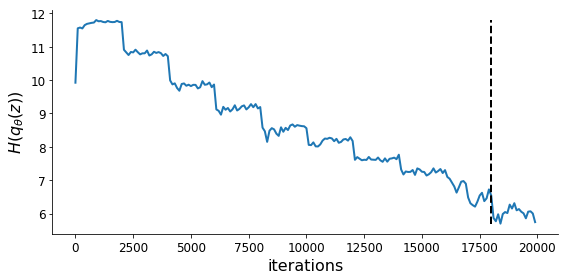

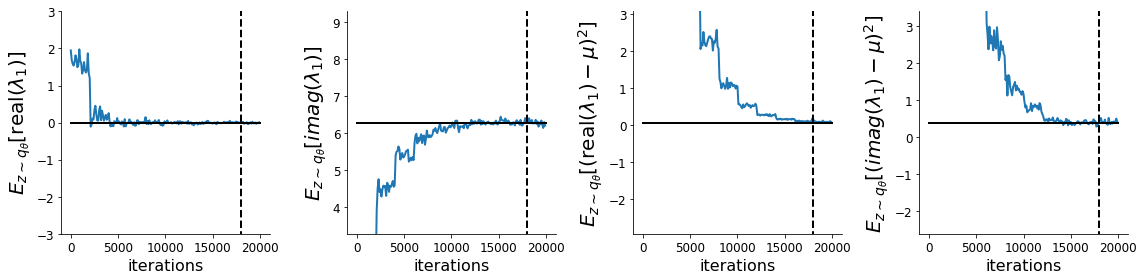

In [4]:
dir_str = '2DLDS/'
model_dirs = [];
legendstrs = [];
for rs in range(start_rs, start_rs+num_rs):
    savedir = get_savedir(system, arch_dict, c_init, rs, dir_str)
    model_dirs.append(savedir)
    legendstr = 'rs=%d' % rs;
    legendstrs.append(legendstr);
    
figs, ME_its = plot_opt(model_dirs, converge_dict, xlim_its=20000, T_x_labels=system.T_x_labels);

### Plot the converged EPI distribution (Fig. SB)

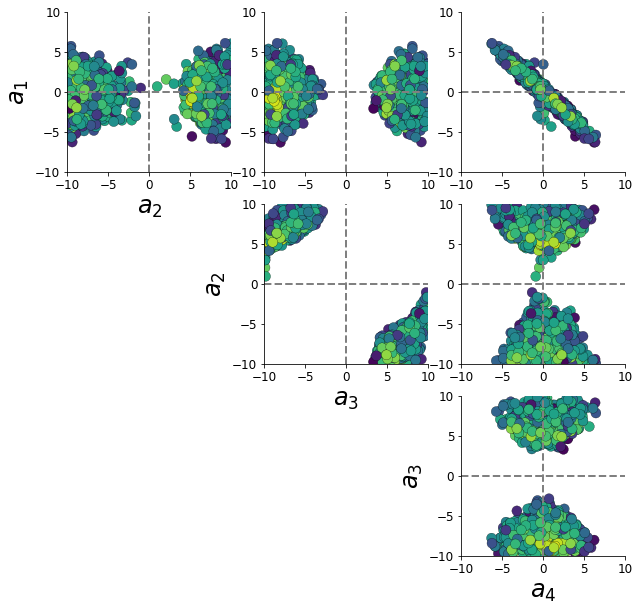

In [5]:
Zs, log_q_zs, axs = dsn_pairplots(model_dirs, 'Zs', system, ME_its, 
                                  xlims=[-10,10], ylims=[-10,10], fontsize=24)
savedir = '../written/NN2019/figures/figS1/'
plt.savefig(savedir + '2DLDS_EPI.pdf')

#### Get colorbar

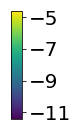

In [60]:
cmap = plt.get_cmap('viridis')
Z = Zs[0]
log_q_z = log_q_zs[0]
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc = ax.scatter(Z[:,1], Z[:,0], c=log_q_z)
cbar = plt.colorbar(sc,ax=ax, aspect=10, ticks=[-5,-7,-9,-11])
cbar.ax.tick_params(labelsize=20) 
ax.remove()
for i in range(1,4):
    savedir = '../written/NN2019/figures/figS%d/' % i
    plt.savefig(savedir + '2DLDS_colorbar.pdf', transparent=True)
plt.show()
colors = sc.to_rgba(log_q_z)

### Probability contours in $a_1$-$a_4$ plane. Fig. S2A

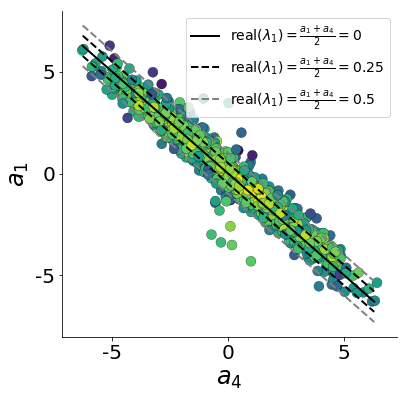

In [6]:
savedir = '../written/NN2019/figures/figS2/'
fontsize = 24
num_linepts = 100
realstd = 0.25

fig, ax = plt.subplots(1,1,figsize=(6,6))
# plot std lines in real(lambda)
x1 = np.linspace(np.min(Z[:,0]), np.max(Z[:,0]), num_linepts)
ax.plot(x1, -x1, 'k')
ax.plot(x1, -(2*realstd)-x1, 'k--')
ax.plot(x1, -(4*realstd)-x1, '--', c='gray')
ax.plot(x1, +(2*realstd)-x1, 'k--')
ax.plot(x1, +(4*realstd)-x1, '--', c='gray')

legendstrs = [r'real$(\lambda_1) = \frac{a_1 + a_4}{2} = 0$',
              r'real$(\lambda_1) = \frac{a_1 + a_4}{2} = 0.25$',
              r'real$(\lambda_1) = \frac{a_1 + a_4}{2} = 0.5$']

ax.legend(legendstrs)
# plot the data-points
x_ind = 3
y_ind = 0
ticks = [-5, 0, 5]

ax.scatter(Z[:,x_ind], Z[:,y_ind], c=log_q_z, 
               edgecolors="k", linewidths=0.25)
ax.set_xlabel(r'$a_4$', fontsize=fontsize)
ax.set_ylabel(r'$a_1$', fontsize=fontsize)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, fontsize=(fontsize-4))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks, fontsize=(fontsize-4))

plt.savefig(savedir + '2DLDS_contour_a1a4.pdf')

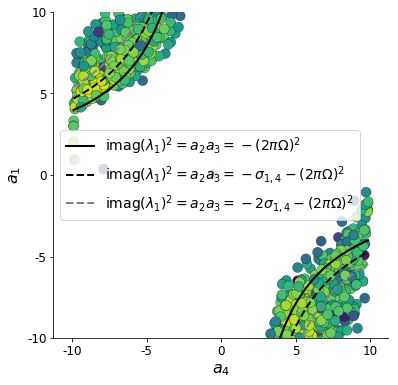

In [61]:
std2 = np.std(Z[:,0]*Z[:,3])
fig, ax = plt.subplots(1,1,figsize=(6,6))

x31 = np.linspace(np.min(Z[:,2]), -0.01, num_linepts//2)
x32 = np.linspace(0.01, np.max(Z[:,2]), num_linepts//2)

ax.plot(x31, -((2*np.pi)**2)/x31, 'k')
ax.plot(x31, (-std2 - ((2*np.pi)**2))/x31, 'k--')
ax.plot(x31, (-2.0*std2 - ((2*np.pi)**2))/x31, '--', c='gray')

ax.plot(x32, -((2*np.pi)**2)/x32, 'k')
ax.plot(x32, (-std2 - ((2*np.pi)**2))/x32, 'k--')
ax.plot(x32, (-2.0*std2 - ((2*np.pi)**2))/x32, '--', c='gray')


ax.set_ylim([-10, 10])
x_ind = 2
y_ind = 1
ticks = [-10, -5, 0, 5, 10]
ax.scatter(Z[:,x_ind], Z[:,y_ind], c=log_q_z, 
               edgecolors="k", linewidths=0.25)
ax.set_xlabel(r'$a_4$', fontsize=fontsize)
ax.set_ylabel(r'$a_1$', fontsize=fontsize)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, fontsize=(fontsize-4))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks, fontsize=(fontsize-4))

legendstrs = [r'imag$(\lambda_1)^2 = a_2 a_3 = - (2 \pi \Omega)^2$',
              r'imag$(\lambda_1)^2 = a_2 a_3 = - \sigma_{1,4} - (2 \pi \Omega)^2$',
              r'imag$(\lambda_1)^2 = a_2 a_3 = - 2\sigma_{1,4} - (2 \pi \Omega)^2$']
ax.legend(legendstrs)

plt.savefig(savedir + '2DLDS_contour_a2a3.pdf')

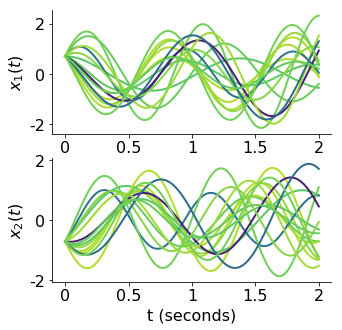

In [63]:
fontsize = 16
savedir = '../written/NN2019/figures/figS3/'

def simulate_2DLDS(x0, A, tau, dt, T):
    def f(x):
        return np.dot(A, x)
    
    x = np.zeros((2, T+1))
    x[:,0] = x0
    x_i = x0
    for i in range(T):
        x_i = x_i + (dt/tau)*f(x_i)
        x[:,i+1] = x_i
    return x

x0 = np.array([np.sqrt(2)/2, -np.sqrt(2)/2])
tau = 1.0
dt = 1e-3
T = 2000
t = np.arange(T+1)*dt

num_traces = 15

fig, axs = plt.subplots(2,1,figsize=(5, 5))
xs = []
for i in range(num_traces):
    A = np.reshape(Z[i,:], (2,2))
    x = simulate_2DLDS(x0, A, tau, dt, T)
    xs.append(x)
    axs[0].plot(t, x[0], c=colors[i])
    axs[1].plot(t, x[1], c=colors[i])
    
t_ticks = [0, 0.5, 1, 1.5, 2]
x_ticks = [-2, 0, 2]
ylabels = [r'$x_1(t)$', r'$x_2(t)$']
for j in range(2):
    axs[j].set_xticks(t_ticks)
    axs[j].set_xticklabels(t_ticks, fontsize=fontsize)
    axs[j].set_yticks(x_ticks)
    axs[j].set_yticklabels(x_ticks, fontsize=fontsize)
    axs[j].set_ylabel(ylabels[j], fontsize=fontsize)
axs[1].set_xlabel('t (seconds)', fontsize=fontsize)

plt.savefig(savedir + '2DLDS_sims_t.pdf')

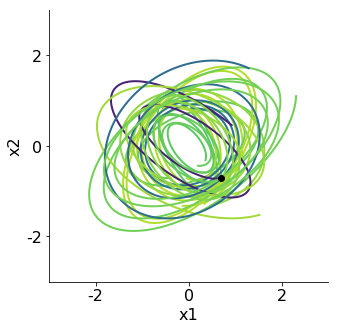

In [62]:
fig, ax = plt.subplots(1,1,figsize=(5, 5))
for i in range(num_traces):
    x = xs[i]
    ax.plot(x[0], x[1], c=colors[i])
    
ax.plot([x0[0]], [x0[1]], 'ok', markersize=6)
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontsize=fontsize)
ax.set_yticks(x_ticks)
ax.set_yticklabels(x_ticks, fontsize=fontsize)
ax.set_xlabel('x1', fontsize=fontsize)
ax.set_ylabel('x2', fontsize=fontsize)

plt.savefig(savedir + '2DLDS_sims_phase.pdf')